# 第2章 自然语言和单词的分布式表示

Marty: “This is heavy（棘手）.”

Dr. Brown: “In the future, things are so heavy（重）?” 

—电影《回到未来》

## 什么是自然语言处理

自然语言 vs 编程语言

本章的主题是让计算机理解单词的含义，本章与下一章讨论3种方法

- 基于同义词词典的方法 **本章**

- 基于计数的方法 **本章**

- 基于推理的方法（word2vec） **下一章**

## 同义词词典

人工编写字典，类似新华字典的性质

![](./img/图2-1.png)

有时在自然语言处理中用到的同义词词典会定义单词之间的粒度更细的关系

比如“上位 - 下位”关系、“整体 - 部分”关系

![](./img/图2-2.png)

### WordNet

在自然语言处理领域，最著名的同义词词典是 WordNet[17]。

WordNet是普林斯顿大学于 1985 年开始开发的同义词词典，迄今已用于许多研究，并活跃于各种自然语言处理应用中。
使用 WordNet，可以获得单词的近义词，或者利用单词网络。


In [1]:
!pip install nltk

You should consider upgrading via the 'd:\anaconda\python.exe -m pip install --upgrade pip' command.


Looking in indexes: http://pypi.douban.com/simple


In [2]:
import nltk

In [3]:
from nltk.corpus import wordnet

In [4]:
# 获得car的词义
wordnet.synsets('car')

[Synset('car.n.01'),
 Synset('car.n.02'),
 Synset('car.n.03'),
 Synset('car.n.04'),
 Synset('cable_car.n.01')]

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
    
**注意！！**

如果出现报错，请把nltk_data解压到search相应的目录

这里car本身有5种不同的含义

car.n.01 表示 car的第一个名词 含义

car 单词名词

n 属性 名词动词等

01 表示簇的索引

In [5]:
# 获得第一个含义的簇
car = wordnet.synset('car.n.01')

In [6]:
# 对该簇调用definition方法 查看词义
car.definition()

'a motor vehicle with four wheels; usually propelled by an internal combustion engine'

In [7]:
# 查看同义词
car.lemma_names()

['car', 'auto', 'automobile', 'machine', 'motorcar']

In [8]:
# 查看单词网络
car.hypernym_paths()

[[Synset('entity.n.01'),
  Synset('physical_entity.n.01'),
  Synset('object.n.01'),
  Synset('whole.n.02'),
  Synset('artifact.n.01'),
  Synset('instrumentality.n.03'),
  Synset('container.n.01'),
  Synset('wheeled_vehicle.n.01'),
  Synset('self-propelled_vehicle.n.01'),
  Synset('motor_vehicle.n.01'),
  Synset('car.n.01')],
 [Synset('entity.n.01'),
  Synset('physical_entity.n.01'),
  Synset('object.n.01'),
  Synset('whole.n.02'),
  Synset('artifact.n.01'),
  Synset('instrumentality.n.03'),
  Synset('conveyance.n.03'),
  Synset('vehicle.n.01'),
  Synset('wheeled_vehicle.n.01'),
  Synset('self-propelled_vehicle.n.01'),
  Synset('motor_vehicle.n.01'),
  Synset('car.n.01')]]

越往上越抽象，越往下越具体

In [9]:
# 格局网络路径计算相似度
car = wordnet.synset('car.n.01')
novel = wordnet.synset('novel.n.01')
dog = wordnet.synset('dog.n.01')
motorcycle = wordnet.synset('motorcycle.n.01')

![](./img/图B-2.png)

In [10]:
car.path_similarity(novel)

0.05555555555555555

In [11]:
car.path_similarity(dog)

0.07692307692307693

In [12]:
car.path_similarity(motorcycle)

0.3333333333333333

相似度返回数值0-1之间，数值越大越相似

### 同义词词典的问题

人工标记的主要问题

- 难以顺应时代变化 crowdfunding，耗子尾汁等

- 人力成本高

- 无法表示单词的微秒差异

## 基于计数的方法

从介绍基于计数的方法开始，我们将使用语料库（corpus）。

语料库就是大量的文本数据。不过，语料库并不是胡乱收集数据，一般收集的都是用于自然语言处理研究和应用的文本数据。

其中的文章都是由人写出来的。

换句话说，语料库中包含了大量的关于自然语言的实践知识，即文章的写作方法、单词的选择方法和单词含义等。

基于计数的方法的目标就是从这些富有实践知识的语料库中，自动且高效地提取本质。

### 基于Python的语料库处理

我们先建一个微微型语料库（corpus）

In [13]:
 text = 'You say goodbye and I say hello.'

In [14]:
# 为了分词处理标点
text = text.lower()
text = text.replace('.', ' .')
text

'you say goodbye and i say hello .'

In [15]:
# 分词
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [16]:
# 单词标注ID
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [17]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [18]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [19]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [20]:
# 我们将上述一系列 处理实现为 preprocess() 函数
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [21]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [22]:
corpus # 单词ID列表

array([0, 1, 2, 3, 4, 1, 5, 6])

In [23]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [24]:
id_to_word 

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

### 单词的分布式表示

颜色可以用不同的数字表示

[中国风颜色](http://zhongguose.com/#mudanfenhong)

能不能把这种方法运用到单词上呢

这种处理就叫做 **分布式表示**

### 分布式假设

在自然语言处理的历史中，用向量表示单词的研究有很多。

如果仔细看一下这些研究，就会发现几乎所有的重要方法都基于一个简单的想法

这个想法就是“某个单词的含义由它周围的单词形成”，称为分布式假设（distributional hypothesis）。

许多用向量表示单词的近期研究也基于该假设。

人是人他妈生的

猪是猪他妈生的

![](./img/图2-3.png)

窗口大小（window size）：下文的大小（即周围的单词有多少个）

### 共现矩阵

![](./img/图2-4.png)

在这个例子中，我们将窗口大小设为 1，从单词 ID 为 0 的 you 开始。

单词 you 的上下文仅有 say 这个单词

![](./img/图2-5.png)

统计 you 的上下文共现的单词的频数。

同时，这也意味着可以用向量 [0, 1, 0, 0, 0, 0, 0] 表示单词 you。

![](./img/图2-7.png)

是汇总了所有单词的共现单词的表格。这个表格的各行对应相应单词的向量。

因为图 2-7 的表格呈矩阵状，所以称为共现矩阵（co-occurence matrix）

In [25]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    '''生成共现矩阵

    :param corpus: 语料库（单词ID列表）
    :param vocab_size:词汇个数
    :param window_size:窗口大小（当窗口大小为1时，左右各1个单词为上下文）
    :return: 共现矩阵
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

In [26]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

In [27]:
C

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]])

其中参数 corpus 是单词 ID 列表，参数 vocab_size 是词汇个数，window_size 是窗口大小

### 向量间的相似度

最常用的余弦相似度（cosine similarity）

余弦相似度直观地表示了“两个向量在多大程度上指向同一方向”。

两个向量完全指向相同的方向时，余弦相似度为 1；完全指向相反的方向时，余弦相似度为 −1。

[推导](https://blog.csdn.net/a5794683/article/details/98386505)

<div class="alert alert-danger alertdanger" style="margin-top: 0px">
    
**思考！！**

为什么可以使用余弦相似度

In [28]:
def cos_similarity(x, y, eps=1e-8):
    '''计算余弦相似度

    :param x: 向量
    :param y: 向量
    :param eps: 用于防止“除数为0”的微小值
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

In [29]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
C

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]])

In [30]:
word_to_id['you']

0

In [31]:
c0 = C[word_to_id['you']] # you的单词向量
c1 = C[word_to_id['i']] # i的单词向量
c0

array([0, 1, 0, 0, 0, 0, 0])

In [32]:
c1

array([0, 1, 0, 1, 0, 0, 0])

In [33]:
print(cos_similarity(c0, c1))

0.7071067691154799


从上面的结果可知，you 和 i 的余弦相似度是 0.70 ...。

由于余弦相似度的取值范围是 −1 到 1，所以可以说这个值是相对比较高的（存在相似性）。

### 相似单词的排序

In [34]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

In [35]:
query, word_to_id, id_to_word, word_matrix, top = 'you', word_to_id, id_to_word, C, 5

In [36]:
print('\n[query] ' + query)


[query] you


In [37]:
query_id = word_to_id[query]
query_id

0

In [38]:
query_vec = word_matrix[query_id]
query_vec

array([0, 1, 0, 0, 0, 0, 0])

In [39]:
vocab_size = len(id_to_word)
vocab_size

7

In [40]:
# 计算余弦相似度
similarity = np.zeros(vocab_size)
similarity

array([0., 0., 0., 0., 0., 0., 0.])

In [41]:
for i in range(vocab_size):
    similarity[i] = cos_similarity(word_matrix[i], query_vec)
similarity

array([0.99999998, 0.        , 0.70710677, 0.        , 0.70710677,
       0.70710677, 0.        ])

In [42]:
# 基于余弦相似度，按降序输出值
count = 0
for i in (-1 * similarity).argsort(): # 
    if id_to_word[i] == query:
        continue
    print(' %s: %s' % (id_to_word[i], similarity[i]))

    count += 1
    if count >= top:
        break

 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


In [43]:
x = np.array([100, -20, 2])
x.argsort()

array([1, 2, 0], dtype=int64)

上述代码对 NumPy 数组 [100, −20, 2] 的各个元素按升序进行了排列。

降序

In [44]:
(-x).argsort()

array([0, 2, 1], dtype=int64)

![](./img/bq1.png)

整合为一个函数

In [45]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''相似单词的查找

    :param query: 查询词
    :param word_to_id: 从单词到单词ID的字典
    :param id_to_word: 从单词ID到单词的字典
    :param word_matrix: 汇总了单词向量的矩阵，假定保存了与各行对应的单词向量
    :param top: 显示到前几位
    '''
    
    # 取出查询词
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)
    # 计算余弦相似度
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
    
    # 基于余弦相似度，按降序输出值
    count = 0
    for i in (-1 * similarity).argsort(): # 
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


试用一下

In [46]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

In [47]:
most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


这里由于数据库比较小，不是非常准确

## 基于计数方法的改进

上一节我们创建了单词的共现矩阵，并使用它成功地将单词表示为了向量。但是，这个共现矩阵还有许多可以改进的地方。

本节我们将对其进行改进，并使用更实用的语料库，获得单词的“真实的”分布式表示。

### 点互信息

规避高频词 the le la les de du 啥的

![](./img/2.2.png)

使用矩阵表示

![](./img/2.3.png)

比如语料库的单词数量（N）为 10 000

the 出现 1000 次

car 出现 20 次

drive 出现 10 次

the 和 car 共现 10 次

car 和 drive 共现 5 次。

这时，如果从共现次数的角度来看，则与 drive 相比，the 和 car 的相关性更强。

而如果从 PMI 的角度来看，结果是怎样的呢？

![](./img/2.4.png)

还有一个问题，当两个单词的共现次数为 0 时，

$log_20 = −∞$

为了解决这个问题，实践上我们会使用下述正的点互信息（Positive PMI，PPMI）

![](./img/2.6.png)

当 PMI 是负数时，将其视为 0，这样就可以将单词间的相关性表示为大于等于 0 的实数。

In [48]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

In [49]:
C=C
eps = 1e-8

In [50]:
C

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]])

In [51]:
M = np.zeros_like(C, dtype=np.float32)
M

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [52]:
N = np.sum(C)
N

14

In [53]:
S = np.sum(C, axis=0)
S

array([1, 4, 2, 2, 2, 2, 1])

In [54]:
total = C.shape[0] * C.shape[1]
total

49

In [55]:
# cnt = 0

In [56]:
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps) #为了防止 np.log2(0)=-inf 而使用了微小值 eps。
        M[i, j] = max(0, pmi)
        print(M[i, j])

0.0
1.8073549
0.0
0.0
0.0
0.0
0.0
1.8073549
0.0
0.8073549
0.0
0.8073549
0.8073549
0.0
0.0
0.8073549
0.0
1.8073549
0.0
0.0
0.0
0.0
0.0
1.8073549
0.0
1.8073549
0.0
0.0
0.0
0.8073549
0.0
1.8073549
0.0
0.0
0.0
0.0
0.8073549
0.0
0.0
0.0
0.0
2.807355
0.0
0.0
0.0
0.0
0.0
2.807355
0.0


In [57]:
np.set_printoptions(precision=3) # 有效位数为3位

In [58]:
M

array([[0.   , 1.807, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [1.807, 0.   , 0.807, 0.   , 0.807, 0.807, 0.   ],
       [0.   , 0.807, 0.   , 1.807, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.807, 0.   , 1.807, 0.   , 0.   ],
       [0.   , 0.807, 0.   , 1.807, 0.   , 0.   , 0.   ],
       [0.   , 0.807, 0.   , 0.   , 0.   , 0.   , 2.807],
       [0.   , 0.   , 0.   , 0.   , 0.   , 2.807, 0.   ]], dtype=float32)

封装为函数

In [59]:
def ppmi(C, verbose=False, eps = 1e-8):
    '''生成PPMI（正的点互信息）

    :param C: 共现矩阵
    :param verbose: 是否输出进展情况
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

这里，参数 C 表示共现矩阵，verbose 是决定是否输出运行情况的标志。

当处理大语料库时，设置 verbose=True，可以用于确认运行情况。

In [60]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)
W

array([[0.   , 1.807, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [1.807, 0.   , 0.807, 0.   , 0.807, 0.807, 0.   ],
       [0.   , 0.807, 0.   , 1.807, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.807, 0.   , 1.807, 0.   , 0.   ],
       [0.   , 0.807, 0.   , 1.807, 0.   , 0.   , 0.   ],
       [0.   , 0.807, 0.   , 0.   , 0.   , 0.   , 2.807],
       [0.   , 0.   , 0.   , 0.   , 0.   , 2.807, 0.   ]], dtype=float32)

In [61]:
np.set_printoptions(precision=3) # 有效位数为3位
print('covariance matrix')
print('-'*30)
print(C)

covariance matrix
------------------------------
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


In [62]:
print('PPMI')
print('-'*45)
print(W)

PPMI
---------------------------------------------
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


这样一来，我们就将共现矩阵转化为了 PPMI 矩阵。

此时，PPMI 矩阵的各个元素均为大于等于 0 的实数。

我们得到了一个由更好的指标形成的矩阵，这相当于获取了一个更好的单词向量。

但是，这个 PPMI 矩阵还是存在一个很大的问题，那就是随着语料库的词汇量增加，各个单词向量的维数也会增加。

如果语料库的词汇量达到10 万，则单词向量的维数也同样会达到 10 万。

实际上，处理 10 万维向量是不现实的。

另外，如果我们看一下这个矩阵，就会发现其中很多元素都是 0。

这表明向量中的绝大多数元素并不重要，也就是说，每个元素拥有的“重要性”很低。

另外，这样的向量也容易受到噪声影响，稳健性差。对于这些问题，一个常见的方法是向量降维。

### 降维

降 维 的 方 法 有 很 多， 这 里 我 们 使 用 奇异值分解（Singular Value Decomposition，SVD）。SVD 将任意矩阵分解为 3 个矩阵的乘积，如下式
所示：

https://blog.csdn.net/zhongkejingwang/article/details/43053513

见xmind

In [63]:
A = np.array([[3, 0],[4, 5]])
A

array([[3, 0],
       [4, 5]])

In [64]:
np.linalg.svd(A)

(array([[-0.316, -0.949],
        [-0.949,  0.316]]),
 array([6.708, 2.236]),
 array([[-0.707, -0.707],
        [-0.707,  0.707]]))

In [65]:
# SVD
U, S, V = np.linalg.svd(A)

In [66]:
U

array([[-0.316, -0.949],
       [-0.949,  0.316]])

In [ ]:
S

In [ ]:
V

### SVD降维

In [67]:
import numpy as np
import matplotlib.pyplot as plt

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

In [68]:
np.set_printoptions(precision=3)  # 有效位数为3位
U, S, V = np.linalg.svd(W)

In [69]:
np.set_printoptions(precision=3)  # 有效位数为3位
U

array([[-3.409e-01, -1.110e-16, -3.886e-16, -1.205e-01,  0.000e+00,
         9.323e-01,  2.226e-16],
       [ 0.000e+00, -5.976e-01,  1.802e-01,  0.000e+00, -7.812e-01,
         0.000e+00,  0.000e+00],
       [-4.363e-01, -4.241e-17, -2.172e-16, -5.088e-01, -1.767e-17,
        -2.253e-01, -7.071e-01],
       [-2.614e-16, -4.978e-01,  6.804e-01, -6.574e-17,  5.378e-01,
         9.951e-17,  1.201e-17],
       [-4.363e-01, -3.229e-17, -1.654e-16, -5.088e-01, -1.345e-17,
        -2.253e-01,  7.071e-01],
       [-7.092e-01, -3.229e-17, -1.654e-16,  6.839e-01, -1.345e-17,
        -1.710e-01,  5.889e-17],
       [ 3.056e-16, -6.285e-01, -7.103e-01,  8.846e-17,  3.169e-01,
        -2.847e-16, -1.546e-17]], dtype=float32)

In [72]:
S

array([3.168e+00, 3.168e+00, 2.703e+00, 2.703e+00, 1.514e+00, 1.514e+00,
       1.484e-16], dtype=float32)

In [73]:
V

array([[ 0.000e+00, -5.976e-01, -2.296e-16, -4.978e-01, -1.186e-16,
         2.145e-16, -6.285e-01],
       [-3.409e-01, -1.110e-16, -4.363e-01,  0.000e+00, -4.363e-01,
        -7.092e-01,  0.000e+00],
       [ 1.205e-01, -5.551e-16,  5.088e-01,  0.000e+00,  5.088e-01,
        -6.839e-01,  0.000e+00],
       [-0.000e+00, -1.802e-01, -1.586e-16, -6.804e-01,  6.344e-17,
         9.119e-17,  7.103e-01],
       [-9.323e-01, -5.551e-17,  2.253e-01,  0.000e+00,  2.253e-01,
         1.710e-01,  0.000e+00],
       [-0.000e+00,  7.812e-01,  2.279e-16, -5.378e-01,  3.390e-16,
        -2.717e-16, -3.169e-01],
       [ 0.000e+00,  2.632e-16, -7.071e-01,  8.043e-18,  7.071e-01,
         9.088e-17,  1.831e-17]], dtype=float32)

In [74]:
print(U[0, :2])

[-3.409e-01 -1.110e-16]


In [75]:
U[0, 0], U[0, 1]

(-0.34094876, -1.110223e-16)

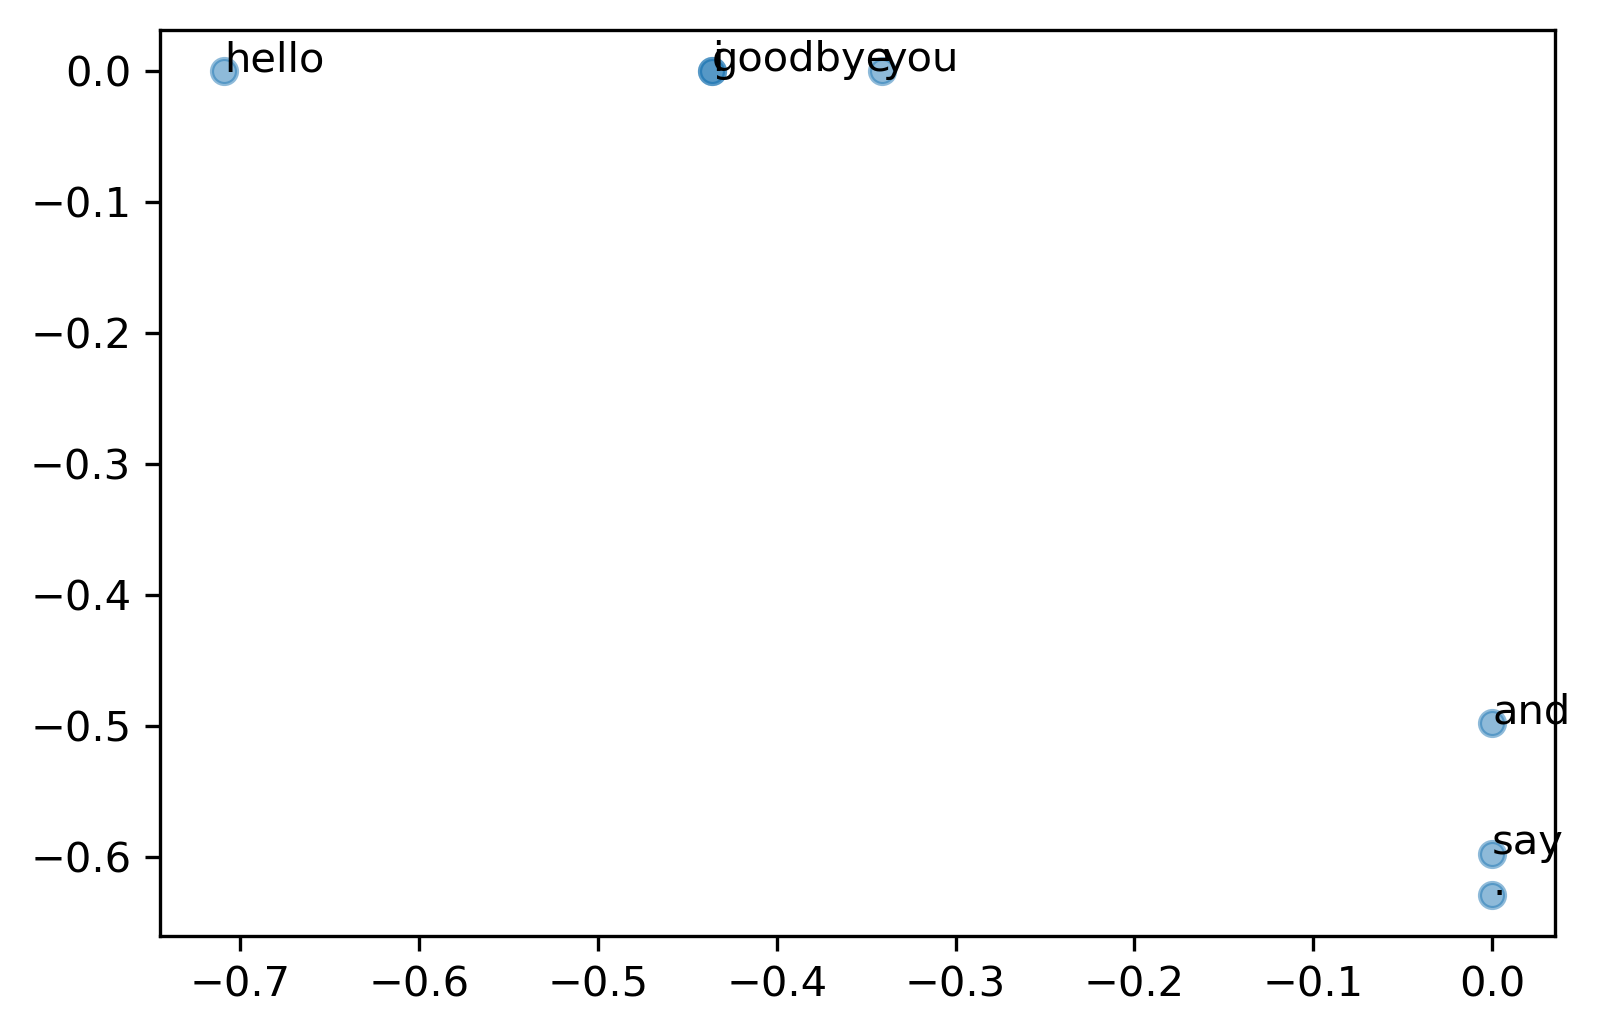

In [76]:
plt.figure(dpi=300)
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

根据操作系统的种类或Matplotlib版本的不同，输出的图可能所有不同。

如果矩阵大小是 N，SVD 的计算的复杂度将达到 O(N3)。

这意味着SVD需要与N的立方成比例的计算量。

因为现实中这样的计算量是做不到的，所以往往会使用Truncated SVD[21]等更快的方法。

Truncated SVD 通过截去（truncated）奇异值较小的部分，从而实现高速化。

下一节，作为另一个选择，我们将使用 sklearn库的 Truncated SVD。

### PTB数据集

Penn Treebank 语料库（以下简称为 PTB）

相比较原始的PTB，本书做了以下处理

- 稀有单词替换成特殊字符 <unk>（unk 是 unknown 的简称）
    
- 将具体的数字替换成“N”
    
- 每个句子的结尾处插入一个特殊字符 <eos>（eos 是 end of sentence 的简称）

数据集手动下载

> 图灵社区配套里有

> http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz

> NLP专题群里有 如果下载了群资料，就不用担心这个了

In [78]:
# dataset/ptb.py
import os
try:
    import urllib.request
except ImportError:
    raise ImportError('Use Python3!')
import pickle
import numpy as np


url_base = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/'
key_file = {
    'train':'ptb.train.txt',
    'test':'ptb.test.txt',
    'valid':'ptb.valid.txt'
}
save_file = {
    'train':'ptb.train.npy',
    'test':'ptb.test.npy',
    'valid':'ptb.valid.npy'
}
vocab_file = 'ptb.vocab.pkl'

dataset_dir = os.path.join(os.path.abspath('.'), 'dataset')
dataset_dir

'D:\\06Jupyter\\03_code\\18深度学习进阶自然语言处理\\神仔的代码\\dataset'

In [80]:
def load_vocab():
    vocab_path = dataset_dir + '/' + vocab_file

    if os.path.exists(vocab_path):
        with open(vocab_path, 'rb') as f:
            word_to_id, id_to_word = pickle.load(f)
        return word_to_id, id_to_word

    word_to_id = {}
    id_to_word = {}
    data_type = 'train'
    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name


    words = open(file_path).read().replace('\n', '<eos>').strip().split()

    for i, word in enumerate(words):
        if word not in word_to_id:
            tmp_id = len(word_to_id)
            word_to_id[word] = tmp_id
            id_to_word[tmp_id] = word

    with open(vocab_path, 'wb') as f:
        pickle.dump((word_to_id, id_to_word), f)

    return word_to_id, id_to_word

In [81]:
def load_data(data_type='train'):
    '''
        :param data_type: 数据的种类：'train' or 'test' or 'valid (val)'
        :return:
    '''
    if data_type == 'val': data_type = 'valid'
    save_path = dataset_dir + '/' + save_file[data_type]

    word_to_id, id_to_word = load_vocab()

    if os.path.exists(save_path):
        corpus = np.load(save_path)
        return corpus, word_to_id, id_to_word

    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name

    words = open(file_path).read().replace('\n', '<eos>').strip().split()
    corpus = np.array([word_to_id[w] for w in words])

    np.save(save_path, corpus)
    return corpus, word_to_id, id_to_word

In [82]:
for data_type in ('train', 'val', 'test'):
    load_data(data_type)

测试

In [83]:
# ch02/show_ptb.py

corpus, word_to_id, id_to_word = load_data('train') # 'train', 'val', 'test'

print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])

corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [84]:
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz


In [85]:
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


语料库的用法和之前一样。

corpus 中保存了单词 ID 列表，

id_to_word 是将单词 ID 转化为单词的字典，

word_to_id 是将单词转化为单词 ID 的字典。

如上面的代码所示，使用 ptb.load_data() 加载数据。

此时，指定参数 'train'、'test' 和 'valid' 中的一个，它们分别对应训练用数据、测试用数据和验证用数据中的一个。


### 基于PTB数据集的评价

In [86]:
# ch02/count_method_big.py
# import sys
# sys.path.append('..')
# import numpy as np
# from common.util import most_similar, create_co_matrix, ppmi
# from dataset import ptb


window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = load_data('train')
vocab_size = len(word_to_id)

counting  co-occurrence ...


In [87]:
print('counting  co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)


calculating PPMI ...


In [88]:
print('calculating PPMI ...')
W = ppmi(C, verbose=True)

calculating PPMI ...


D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in long_scalars
  app.launch_new_instance()
D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log2
  app.launch_new_instance()


1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.0% done
89.0% done
90.0% done
91.0% done
92.0% do

In [89]:
# truncated SVD (fast!)
from sklearn.utils.extmath import randomized_svd
U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                         random_state=None)

这里，为了执行 SVD，我们使用了 sklearn 的 randomized_svd() 方法。

该方法通过使用了随机数的 Truncated SVD，仅对奇异值较大的部分进行计算，计算速度比常规的 SVD 快。

剩余的代码和之前使用小语料库时的代码差不太多。

执行代码，可以得以下结果（因为使用了随机数，所以在使用Truncated SVD 的情况下，每次的结果都不一样）。

In [90]:
word_vecs = U[:, :wordvec_size]

In [91]:
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 i: 0.6842135190963745
 we: 0.661026120185852
 'd: 0.5637916922569275
 do: 0.5449517369270325
 someone: 0.48873811960220337

[query] year
 month: 0.6704140901565552
 quarter: 0.6585443019866943
 next: 0.6276336312294006
 last: 0.6167846918106079
 earlier: 0.579169511795044

[query] car
 luxury: 0.6046832799911499
 auto: 0.5876185894012451
 domestic: 0.5353754758834839
 cars: 0.5169938206672668
 lexus: 0.5169932246208191

[query] toyota
 motor: 0.7448468804359436
 motors: 0.6645057201385498
 nissan: 0.6196011900901794
 lexus: 0.6177109479904175
 infiniti: 0.5513126850128174


观察结果可知，首先，对于查询词 you，可以看到 i、we 等人称代词排在前面，这些都是在语法上具有相同用法的词。

再者，查询词 year 有month、quarter 等近义词，查询词 car 有 auto、vehicle 等近义词。

此外，将 toyota 作为查询词时，出现了 nissan、honda 和 lexus 等汽车制造商名或者品牌名。

像这样，在含义或语法上相似的单词表示为相近的向量，这符合我们的直觉

## 小结